In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, DistributedSampler
#import torchvision
#import lightning


In [2]:
# data_dir = os.path.join(os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/data_batch_1")
data_dir = os.path.join(
    os.path.dirname(os.getcwd()),
    "Data/CIFAR10/cifar-10-batches-py",
    "train_data.pkl",
)
data_dir_val = os.path.join(
    os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py/test_batch"
)
# batch_size = 2
num_in_channels = 3
dim_z = 32
kern_size = 4
lr = 2e-4
num_epochs = 3

num_disc_feat = 64
disc_stride = 1
disc_padding_size = 0

num_gen_feat = 64
gen_stride = 3
gen_padding_size = 1

mean = 0.0
std = 0.02  # from the DCGAN paper

if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"
else:
    device = "cpu"


In [3]:
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [73]:
def process_data(folder_dir):
    file_paths = os.listdir(folder_dir)
    combined_img_data = []
    combined_label_data = []
    for file in file_paths:
        if "data_batch" in file:
            combined_img_data.append(
                unpickle(os.path.join(folder_dir, file))[b"data"]
            )
            combined_label_data.append(
                unpickle(os.path.join(folder_dir, file))[b"labels"]
            )
    combined_img_data = np.concatenate(combined_img_data)
    combined_label_data = np.concatenate(combined_label_data)
    # with open(os.path.join(folder_dir, "train_img_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_img_data, f)
    # with open(os.path.join(folder_dir, "train_label_data.pkl"), 'wb') as f:
    #     pickle.dump(combined_label_data, f)

    train_data = {}
    train_data[b"data"] = combined_img_data
    train_data[b"labels"] = combined_label_data
    with open(os.path.join(folder_dir, "train_data.pkl"), "wb") as f:
        pickle.dump(train_data, f)

In [ ]:
process_data(
    os.path.join(
        os.path.dirname(os.getcwd()), "Data/CIFAR10/cifar-10-batches-py"
    )
)

In [74]:
(unpickle(data_dir).keys())


dict_keys([b'data', b'labels'])

In [39]:
class TrainDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.train_data = unpickle(data_dir)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.train_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0)/255.0,
            dtype=torch.float32,
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(
            self.train_data[b"labels"][idx], dtype=torch.float32
        )
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.train_data[b"labels"])

In [40]:
class ValDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.val_data = unpickle(data_dir)

    def __getitem__(self, idx):
        img = torch.tensor(
            self.val_data[b"data"][idx].reshape(3, 32, 32).transpose(1, 2, 0) / 255.0, dtype=torch.float32
        )
        # img = torch.nn.functional.normalize(img)
        label = torch.tensor(self.val_data[b"labels"][idx], dtype=torch.float32)
        # return img, label
        return {"img": img, "label": label}

    def __len__(self):
        return len(self.val_data[b"labels"])

In [41]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            # nn.BatchNorm2d(num_in_channels),
            nn.Conv2d(
                num_in_channels,
                num_disc_feat,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat,
                num_disc_feat * 2,
                kern_size,
                4,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 2),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 2,
                num_disc_feat * 4,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(num_disc_feat * 4),
            nn.LeakyReLU(),
            nn.Conv2d(
                num_disc_feat * 4,
                1,
                kern_size,
                disc_stride,
                disc_padding_size,
                bias=False,
            ),
            nn.BatchNorm2d(1),
            nn.LeakyReLU()
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [42]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                dim_z, num_gen_feat * 4, kern_size, 1, 0, bias=False
            ),
            # ConvTranspose2d are the fractionally strided convolutions used for upscaling mentioned in the paper
            nn.BatchNorm2d(num_gen_feat * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 4, num_gen_feat * 2, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat * 2, num_gen_feat, kern_size, 2, 1, bias=False
            ),
            nn.BatchNorm2d(num_gen_feat),
            nn.ReLU(),
            nn.ConvTranspose2d(
                num_gen_feat, num_in_channels, kern_size, 2, 1, bias=False
            ),
            nn.Tanh(),
        )

        for layer in self.net.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                nn.init.normal_(layer.weight, mean, std)

    def forward(self, x):
        z = self.net(x)
        return z

In [43]:
train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0, shuffle=True)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)

val_dataset = ValDataset(data_dir_val)
val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0, shuffle=True)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=100,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=val_sampler,
)

In [49]:
def train(num_epochs, data_dir, data_dir_val, device, train=True, **kwargs):

    loss_fn = torch.nn.BCEWithLogitsLoss()

    train_dataset = TrainDataset(data_dir)
    train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0)
    batch_size = kwargs.get("batch_size", 100)
    gen_lr = kwargs.get("gen_lr", 2e-4)
    disc_lr = kwargs.get("disc_lr", 2e-4)
    k = kwargs.get("k", 1)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=train_sampler,
    )
    if train == False:
        val_dataset = ValDataset(data_dir_val)
        val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            sampler=val_sampler,
        )
    
    optimG = torch.optim.AdamW(gen.parameters(), lr=gen_lr, betas=(0.5, 0.0), weight_decay=0.2)
    optimD = torch.optim.AdamW(disc.parameters(), lr=disc_lr, betas=(0.5, 0.0), weight_decay=0.1)
    # optimD = torch.optim.SGD(disc.parameters(), lr=2e-4)

    # noise = torch.randn(28, dim_z, 1, 1, device=device)

    # real_label = 1
    # fake_label = 0
    loss_d, loss_g, imgs = [], [], []
    
    if train:
        for i in range(num_epochs):
            print(f"Epoch no. :  {i+1}")
            nan_flag = False
            if nan_flag==False:
                
                for _ in range(k):
                        
                    for j, mini_batch in enumerate(train_loader):
                        
                        optimD.zero_grad()
                        
                        # train disc first
                        x_real = mini_batch["img"].to(device)
                        x_real = x_real.view(batch_size, num_in_channels, 32, 32)
                        labels = torch.full(
                            (batch_size,), 1.0, dtype=torch.float32, device=device
                        )
                        # out_disc_r = disc(x_real).flatten().sigmoid()
                        out_disc_r = disc(x_real).flatten()

                        # print(out_disc_r)
                        loss_disc_r = loss_fn(out_disc_r, labels)
                        loss_disc_r.backward()

                        x_fake = gen(torch.randn(batch_size, dim_z, 1, 1, device=device))
                        labels = torch.full(
                            (batch_size,), 0.0, dtype=torch.float32, device=device
                        )
                        # out_disc_f = disc(x_fake).flatten().sigmoid()
                        out_disc_f = disc(x_fake).flatten()
                        loss_disc_f = loss_fn(out_disc_f, labels)
                        if torch.isnan(loss_disc_f) or torch.isnan(loss_disc_r):
                            nan_flag = True
                            break
                            
                        loss_disc_f.backward()

                        loss_disc = (
                            loss_disc_f.mean().item() + loss_disc_r.mean().item()
                        ) / 2.0
                        
                        loss_d.append(loss_disc)
                        
                        if j % 100 == 0:
                            print(f"Discriminator loss after {j} steps = {loss_d[j + _*train_dataset.__len__()//batch_size + i*train_dataset.__len__()//batch_size]}")
                            
                        optimD.step()
                    
                for j, mini_batch in enumerate(train_loader):

                    # train gen
                    optimG.zero_grad()

                    x_gen = gen(torch.randn(batch_size, dim_z, 1, 1, device=device))
                    x_gen = torch.nn.functional.normalize(x_gen)
                    # out = disc(x_gen).flatten().sigmoid()
                    out = disc(x_gen).flatten()
                    labels = torch.full(
                        (batch_size,), 1.0, dtype=torch.float32, device=device
                    )
                    loss_gen = loss_fn(out, labels)
                    loss_gen.backward()

                    loss_g.append(loss_gen.item())

                    if loss_disc == np.NaN or loss_gen.item() == np.NaN:
                        nan_flag = True
                        break

                    optimG.step()

                    if j % 100 == 0:
                        print(f"Generator loss after {j} steps = {loss_g[j + i*train_dataset.__len__()//batch_size]}")

                    if j%500 == 0:
                        with torch.no_grad():
                            gen_img = gen(torch.randn(2, dim_z, 1, 1, device=device))
                            imgs.append(gen_img[0])
                            plt.imshow(gen_img[0].reshape(32, 32, 3).cpu().detach().numpy())
                            plt.show()
                            plt.imshow(mini_batch['img'][0].cpu().reshape(32, 32, 3).numpy())
                            plt.show()
                
    return loss_d, loss_g, imgs

In [53]:
disc = Discriminator().to(device)
gen = Generator().to(device)
loss_disc, loss_gen, images = [], [], []


Epoch no. :  1
Discriminator loss after 0 steps = 0.7476171553134918
Discriminator loss after 100 steps = 0.7359153032302856
Discriminator loss after 200 steps = 0.7309716641902924
Discriminator loss after 300 steps = 0.7279630303382874
Discriminator loss after 400 steps = 0.6778085231781006
Discriminator loss after 500 steps = 0.6725187599658966
Discriminator loss after 600 steps = 0.7032009065151215
Discriminator loss after 700 steps = 0.6879763603210449
Discriminator loss after 800 steps = 0.670512318611145
Discriminator loss after 900 steps = 0.6962794959545135
Discriminator loss after 0 steps = 0.6858229637145996
Discriminator loss after 100 steps = 0.6700192987918854
Discriminator loss after 200 steps = 0.6739630997180939
Discriminator loss after 300 steps = 0.6711679995059967
Discriminator loss after 400 steps = 0.6735475063323975
Discriminator loss after 500 steps = 0.6802869141101837
Discriminator loss after 600 steps = 0.6602363586425781
Discriminator loss after 700 steps = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.5753619074821472


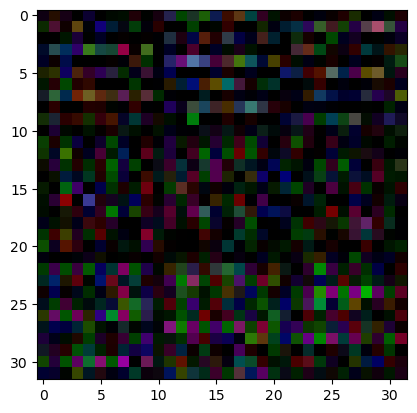

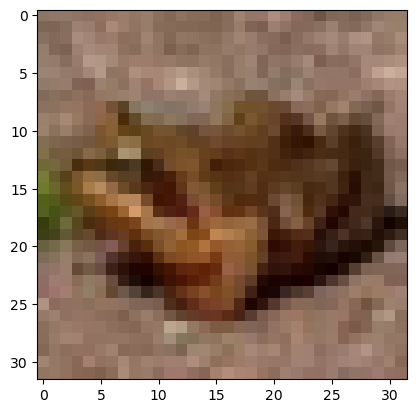

Generator loss after 100 steps = 0.5804713368415833
Generator loss after 200 steps = 0.572297215461731
Generator loss after 300 steps = 0.565567672252655
Generator loss after 400 steps = 0.5560846328735352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5633496046066284


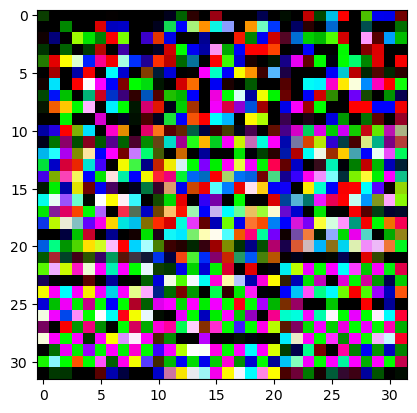

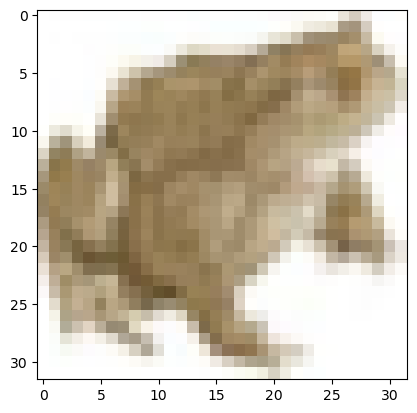

Generator loss after 600 steps = 0.5543368458747864
Generator loss after 700 steps = 0.5544530749320984
Generator loss after 800 steps = 0.5511912703514099
Generator loss after 900 steps = 0.5439772605895996
Epoch no. :  2
Discriminator loss after 0 steps = 0.6858229637145996
Discriminator loss after 100 steps = 0.6700192987918854
Discriminator loss after 200 steps = 0.6739630997180939
Discriminator loss after 300 steps = 0.6711679995059967
Discriminator loss after 400 steps = 0.6735475063323975
Discriminator loss after 500 steps = 0.6802869141101837
Discriminator loss after 600 steps = 0.6602363586425781
Discriminator loss after 700 steps = 0.665369063615799
Discriminator loss after 800 steps = 0.6598412692546844
Discriminator loss after 900 steps = 0.6598019003868103
Discriminator loss after 0 steps = 0.7259613871574402
Discriminator loss after 100 steps = 0.6734005510807037
Discriminator loss after 200 steps = 0.6689796149730682
Discriminator loss after 300 steps = 0.66840460896492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6252827644348145


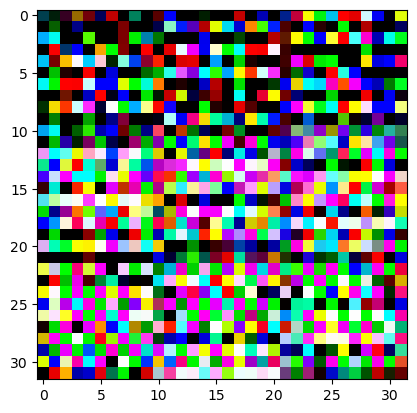

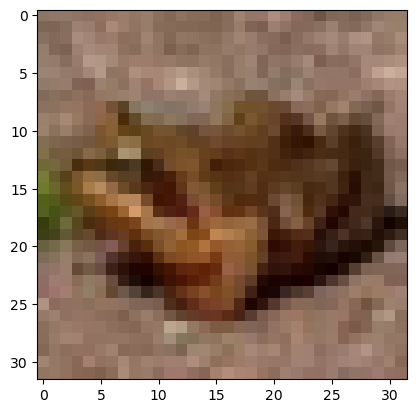

Generator loss after 100 steps = 0.5428652763366699
Generator loss after 200 steps = 0.5301184058189392
Generator loss after 300 steps = 0.5305188894271851
Generator loss after 400 steps = 0.5258890986442566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5449597239494324


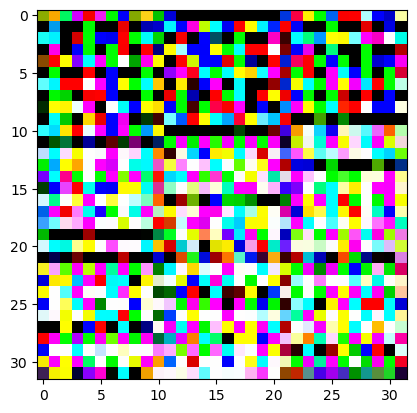

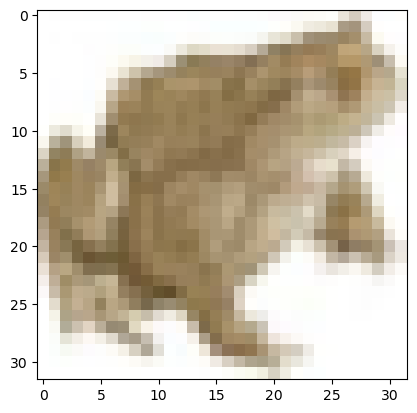

Generator loss after 600 steps = 0.5308277606964111
Generator loss after 700 steps = 0.539216935634613
Generator loss after 800 steps = 0.5328048467636108
Generator loss after 900 steps = 0.528596818447113
Epoch no. :  3
Discriminator loss after 0 steps = 0.7259613871574402
Discriminator loss after 100 steps = 0.6734005510807037
Discriminator loss after 200 steps = 0.6689796149730682
Discriminator loss after 300 steps = 0.66840460896492
Discriminator loss after 400 steps = 0.6594370901584625
Discriminator loss after 500 steps = 0.6573544442653656
Discriminator loss after 600 steps = 0.634901762008667
Discriminator loss after 700 steps = 0.6471356749534607
Discriminator loss after 800 steps = 0.6528924107551575
Discriminator loss after 900 steps = 0.633552074432373
Discriminator loss after 0 steps = 0.6356574594974518
Discriminator loss after 100 steps = 0.645098477602005
Discriminator loss after 200 steps = 0.6295718848705292
Discriminator loss after 300 steps = 0.6330971717834473
Disc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6845444440841675


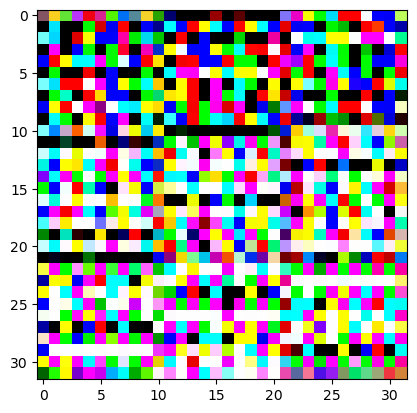

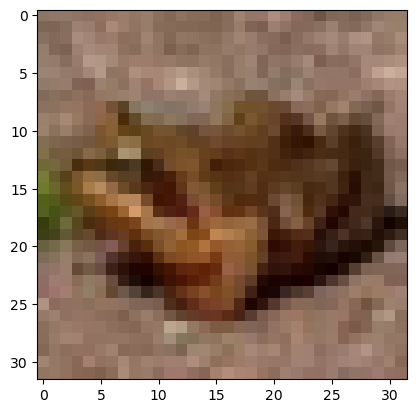

Generator loss after 100 steps = 0.5354145765304565
Generator loss after 200 steps = 0.534574568271637
Generator loss after 300 steps = 0.5524614453315735
Generator loss after 400 steps = 0.5377432107925415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5346375703811646


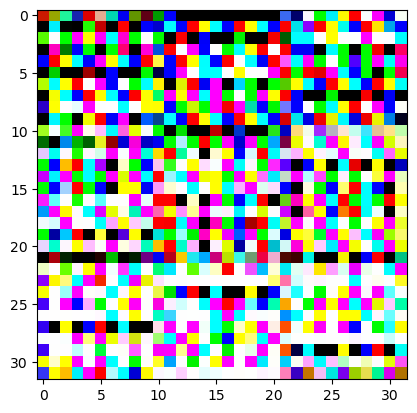

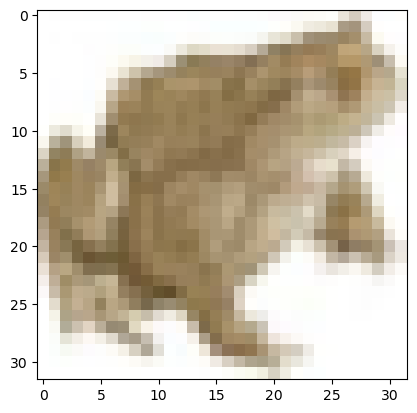

Generator loss after 600 steps = 0.5451590418815613
Generator loss after 700 steps = 0.5288966298103333
Generator loss after 800 steps = 0.5290793180465698
Generator loss after 900 steps = 0.5306681394577026
Epoch no. :  4
Discriminator loss after 0 steps = 0.6356574594974518
Discriminator loss after 100 steps = 0.645098477602005
Discriminator loss after 200 steps = 0.6295718848705292
Discriminator loss after 300 steps = 0.6330971717834473
Discriminator loss after 400 steps = 0.6371099650859833
Discriminator loss after 500 steps = 0.6486267447471619
Discriminator loss after 600 steps = 0.6425844430923462
Discriminator loss after 700 steps = 0.6332030892372131
Discriminator loss after 800 steps = 0.6322285532951355
Discriminator loss after 900 steps = 0.6319815218448639
Discriminator loss after 0 steps = 0.7240298092365265
Discriminator loss after 100 steps = 0.6655276715755463
Discriminator loss after 200 steps = 0.6600911617279053
Discriminator loss after 300 steps = 0.666589230298996

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6936519742012024


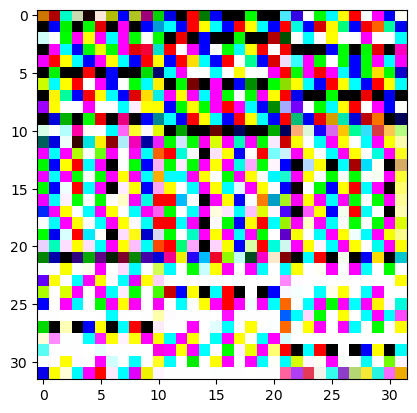

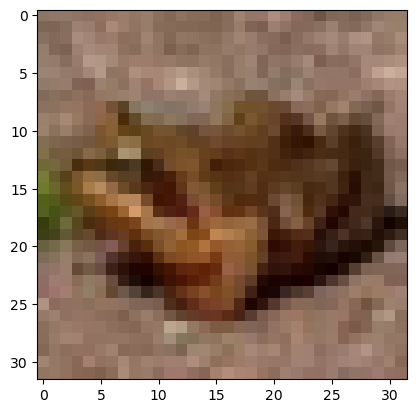

Generator loss after 100 steps = 0.543129026889801
Generator loss after 200 steps = 0.5762487053871155
Generator loss after 300 steps = 0.5800244808197021
Generator loss after 400 steps = 0.5353643298149109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5312846899032593


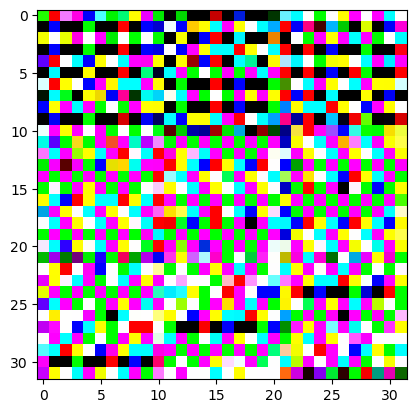

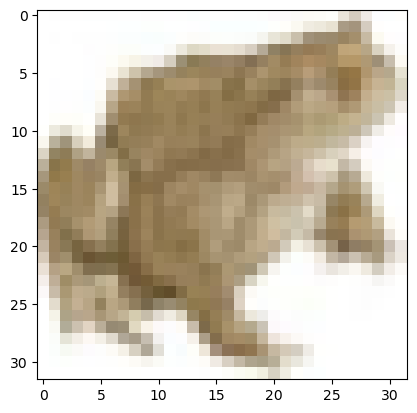

Generator loss after 600 steps = 0.5238237380981445
Generator loss after 700 steps = 0.5261369943618774
Generator loss after 800 steps = 0.5310652256011963
Generator loss after 900 steps = 0.5266135931015015
Epoch no. :  5
Discriminator loss after 0 steps = 0.7240298092365265
Discriminator loss after 100 steps = 0.6655276715755463
Discriminator loss after 200 steps = 0.6600911617279053
Discriminator loss after 300 steps = 0.666589230298996
Discriminator loss after 400 steps = 0.6256681382656097
Discriminator loss after 500 steps = 0.6233157813549042
Discriminator loss after 600 steps = 0.6176905632019043
Discriminator loss after 700 steps = 0.6446399986743927
Discriminator loss after 800 steps = 0.6307410895824432
Discriminator loss after 900 steps = 0.6271339654922485
Discriminator loss after 0 steps = 0.6195581257343292
Discriminator loss after 100 steps = 0.6783706545829773
Discriminator loss after 200 steps = 0.6261270940303802
Discriminator loss after 300 steps = 0.614999026060104

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6790220737457275


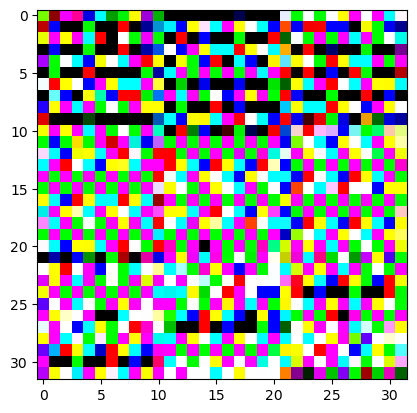

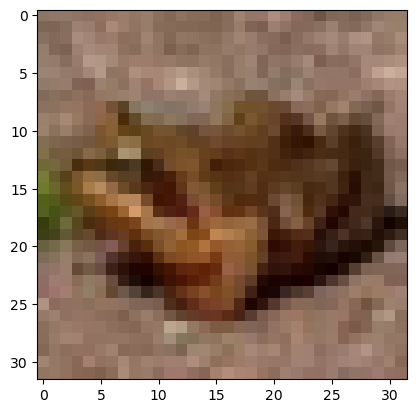

Generator loss after 100 steps = 0.5423232316970825
Generator loss after 200 steps = 0.5408439636230469
Generator loss after 300 steps = 0.537277340888977
Generator loss after 400 steps = 0.5176888108253479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5237526297569275


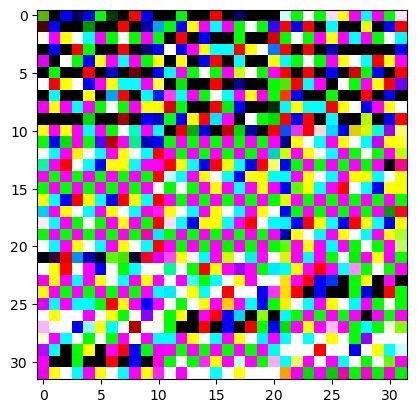

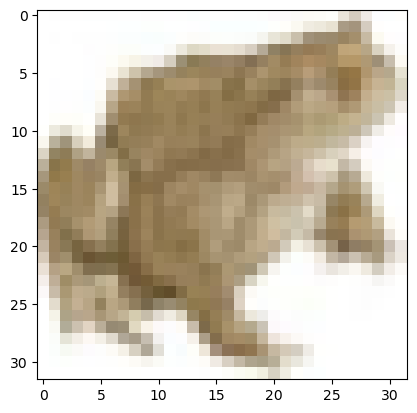

Generator loss after 600 steps = 0.5186895728111267
Generator loss after 700 steps = 0.5266379714012146
Generator loss after 800 steps = 0.5356531143188477
Generator loss after 900 steps = 0.532514750957489
Epoch no. :  6
Discriminator loss after 0 steps = 0.6195581257343292
Discriminator loss after 100 steps = 0.6783706545829773
Discriminator loss after 200 steps = 0.6261270940303802
Discriminator loss after 300 steps = 0.6149990260601044
Discriminator loss after 400 steps = 0.61583611369133
Discriminator loss after 500 steps = 0.617618054151535
Discriminator loss after 600 steps = 0.6173751652240753
Discriminator loss after 700 steps = 0.6152729392051697
Discriminator loss after 800 steps = 0.6128649115562439
Discriminator loss after 900 steps = 0.6237645745277405
Discriminator loss after 0 steps = 0.7256034910678864
Discriminator loss after 100 steps = 0.6492448151111603
Discriminator loss after 200 steps = 0.6228398978710175
Discriminator loss after 300 steps = 0.6203180849552155
D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6599985957145691


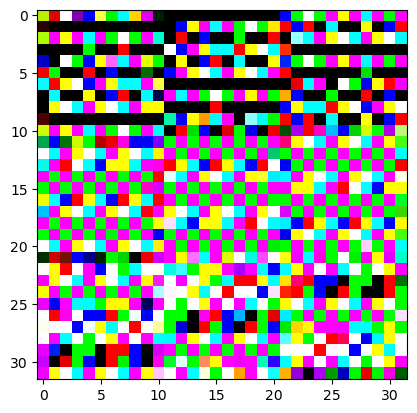

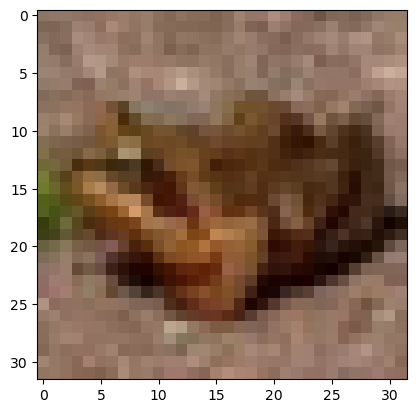

Generator loss after 100 steps = 0.5465450286865234
Generator loss after 200 steps = 0.5449875593185425
Generator loss after 300 steps = 0.532720685005188
Generator loss after 400 steps = 0.5446478724479675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5380856990814209


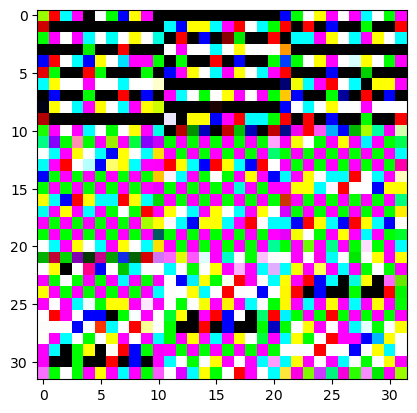

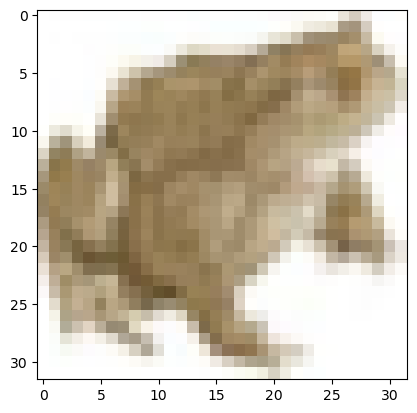

Generator loss after 600 steps = 0.52846759557724
Generator loss after 700 steps = 0.5415745377540588
Generator loss after 800 steps = 0.5317857265472412
Generator loss after 900 steps = 0.5206575393676758
Epoch no. :  7
Discriminator loss after 0 steps = 0.7256034910678864
Discriminator loss after 100 steps = 0.6492448151111603
Discriminator loss after 200 steps = 0.6228398978710175
Discriminator loss after 300 steps = 0.6203180849552155
Discriminator loss after 400 steps = 0.6144502460956573
Discriminator loss after 500 steps = 0.6108942031860352
Discriminator loss after 600 steps = 0.6131441295146942
Discriminator loss after 700 steps = 0.6092512607574463
Discriminator loss after 800 steps = 0.6224449574947357
Discriminator loss after 900 steps = 0.6141106486320496
Discriminator loss after 0 steps = 0.6116184890270233
Discriminator loss after 100 steps = 0.6137120127677917
Discriminator loss after 200 steps = 0.6160740852355957
Discriminator loss after 300 steps = 0.6318307518959045

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6950132846832275


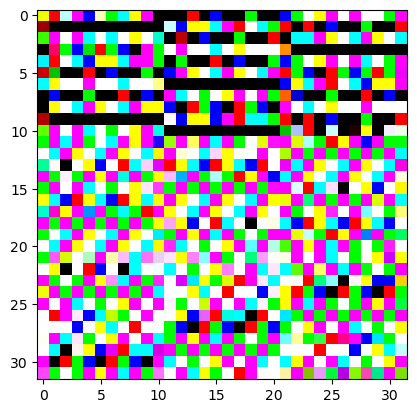

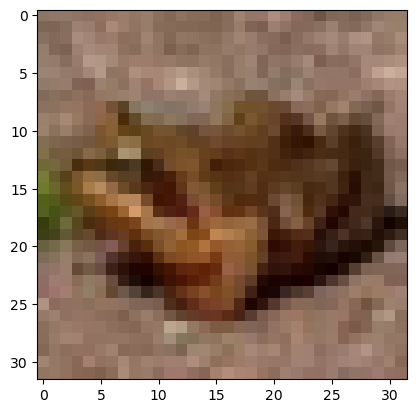

Generator loss after 100 steps = 0.5934706330299377
Generator loss after 200 steps = 0.5978968739509583
Generator loss after 300 steps = 0.602448046207428
Generator loss after 400 steps = 0.5966179370880127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5966028571128845


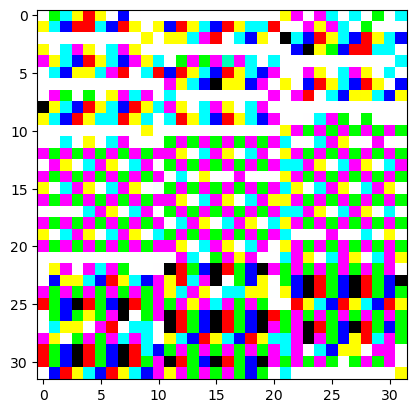

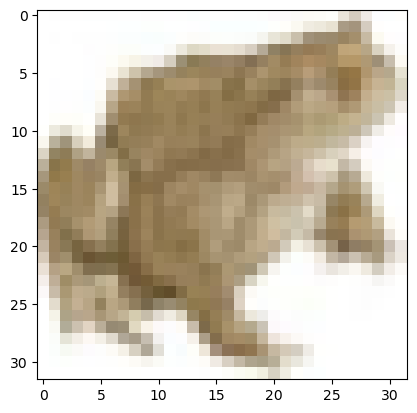

Generator loss after 600 steps = 0.6075632572174072
Generator loss after 700 steps = 0.5878658890724182
Generator loss after 800 steps = 0.6058007478713989
Generator loss after 900 steps = 0.6014219522476196
Epoch no. :  8
Discriminator loss after 0 steps = 0.6116184890270233
Discriminator loss after 100 steps = 0.6137120127677917
Discriminator loss after 200 steps = 0.6160740852355957
Discriminator loss after 300 steps = 0.6318307518959045
Discriminator loss after 400 steps = 0.6434547901153564
Discriminator loss after 500 steps = 0.6099088490009308
Discriminator loss after 600 steps = 0.6380435824394226
Discriminator loss after 700 steps = 0.610832929611206
Discriminator loss after 800 steps = 0.6071783304214478
Discriminator loss after 900 steps = 0.62087681889534
Discriminator loss after 0 steps = 0.7404490411281586
Discriminator loss after 100 steps = 0.6392109990119934
Discriminator loss after 200 steps = 0.6293702721595764
Discriminator loss after 300 steps = 0.6273573338985443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6848008632659912


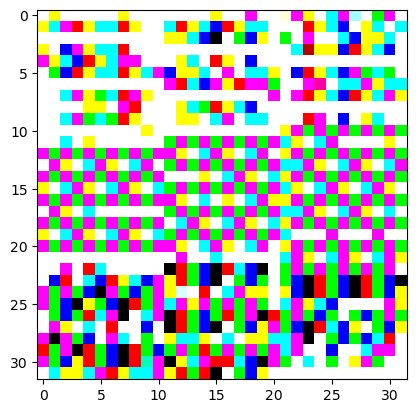

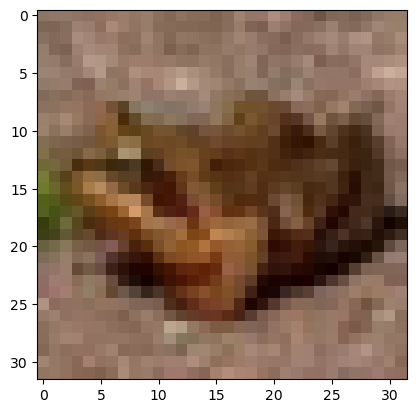

Generator loss after 100 steps = 0.5992333292961121
Generator loss after 200 steps = 0.5933453440666199
Generator loss after 300 steps = 0.5899680256843567
Generator loss after 400 steps = 0.5746070742607117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.6965867280960083


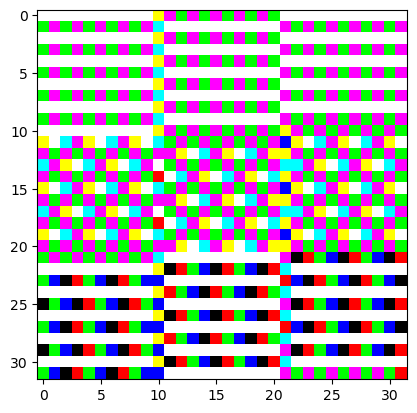

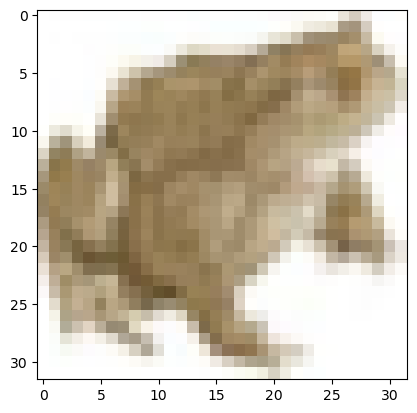

Generator loss after 600 steps = 0.6965867280960083
Generator loss after 700 steps = 0.6965867280960083
Generator loss after 800 steps = 0.6965867280960083
Generator loss after 900 steps = 0.6965867280960083
Epoch no. :  9
Discriminator loss after 0 steps = 0.7404490411281586
Discriminator loss after 100 steps = 0.6392109990119934
Discriminator loss after 200 steps = 0.6293702721595764
Discriminator loss after 300 steps = 0.6273573338985443
Discriminator loss after 400 steps = 0.6154375672340393
Discriminator loss after 500 steps = 0.6325189471244812
Discriminator loss after 600 steps = 0.6102605164051056
Discriminator loss after 700 steps = 0.7285371422767639
Discriminator loss after 800 steps = 0.6066939830780029
Discriminator loss after 900 steps = 0.6095563471317291
Discriminator loss after 0 steps = 0.6134593784809113
Discriminator loss after 100 steps = 0.6206670701503754
Discriminator loss after 200 steps = 0.6357241272926331
Discriminator loss after 300 steps = 0.61167284846305

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6961550712585449


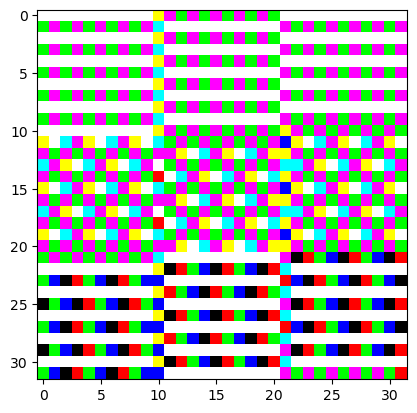

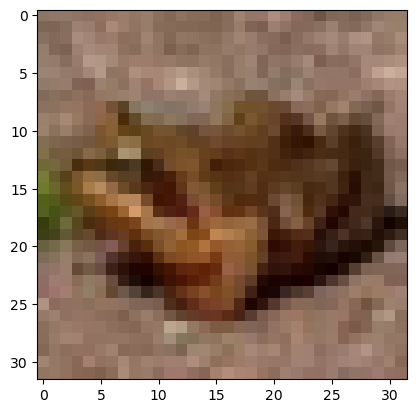

Generator loss after 100 steps = 0.6961550712585449
Generator loss after 200 steps = 0.6961550712585449
Generator loss after 300 steps = 0.6961550712585449
Generator loss after 400 steps = 0.6961550712585449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.6961550712585449


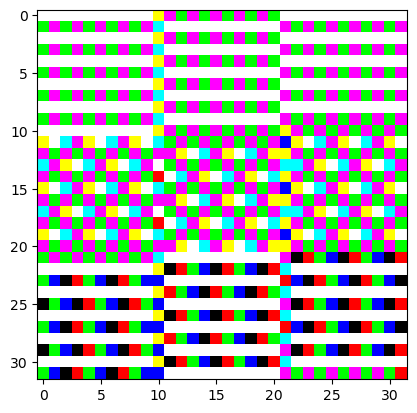

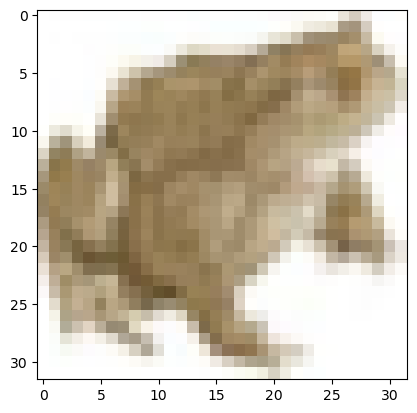

Generator loss after 600 steps = 0.6961550712585449
Generator loss after 700 steps = 0.6961550712585449
Generator loss after 800 steps = 0.6961550712585449
Generator loss after 900 steps = 0.6961550712585449
Epoch no. :  10
Discriminator loss after 0 steps = 0.6134593784809113
Discriminator loss after 100 steps = 0.6206670701503754
Discriminator loss after 200 steps = 0.6357241272926331
Discriminator loss after 300 steps = 0.6116728484630585
Discriminator loss after 400 steps = 0.6186180412769318
Discriminator loss after 500 steps = 0.6113677024841309
Discriminator loss after 600 steps = 0.6113203763961792
Discriminator loss after 700 steps = 0.6073745787143707
Discriminator loss after 800 steps = 0.6037076115608215
Discriminator loss after 900 steps = 0.6328018009662628
Discriminator loss after 0 steps = 0.7257017195224762
Discriminator loss after 100 steps = 0.6513305008411407
Discriminator loss after 200 steps = 0.6296360492706299
Discriminator loss after 300 steps = 0.6420021653175

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.695724368095398


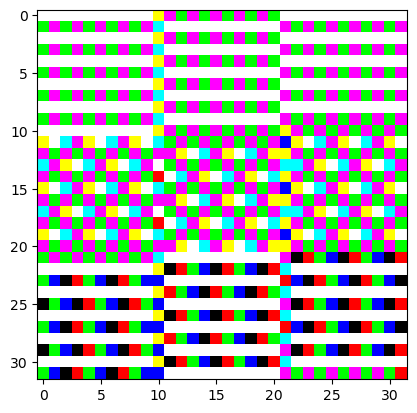

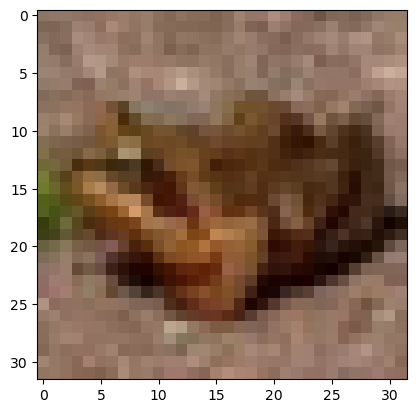

Generator loss after 100 steps = 0.695724368095398
Generator loss after 200 steps = 0.695724368095398
Generator loss after 300 steps = 0.695724368095398
Generator loss after 400 steps = 0.695724368095398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.695724368095398


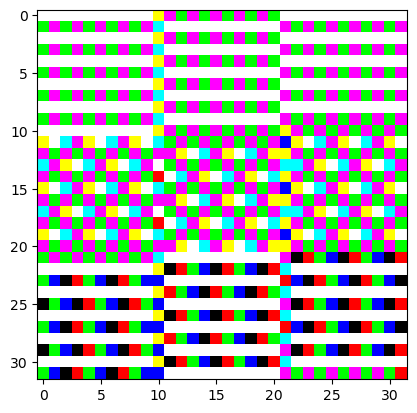

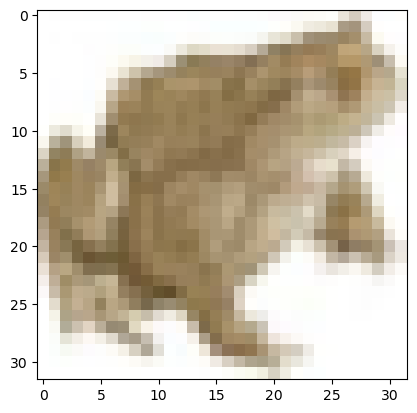

Generator loss after 600 steps = 0.695724368095398
Generator loss after 700 steps = 0.695724368095398
Generator loss after 800 steps = 0.695724368095398
Generator loss after 900 steps = 0.695724368095398
Epoch no. :  1
Discriminator loss after 0 steps = 0.7723676264286041
Discriminator loss after 100 steps = 0.7097398340702057
Discriminator loss after 200 steps = 0.7123063802719116
Discriminator loss after 300 steps = 0.7037428319454193
Discriminator loss after 400 steps = 0.7066794335842133
Discriminator loss after 500 steps = 0.7015012204647064
Discriminator loss after 600 steps = 0.7197881937026978
Discriminator loss after 700 steps = 0.6992100477218628
Discriminator loss after 800 steps = 0.6951736807823181
Discriminator loss after 900 steps = 0.6725219786167145
Discriminator loss after 0 steps = 0.7065108716487885
Discriminator loss after 100 steps = 0.690880298614502
Discriminator loss after 200 steps = 0.6892008185386658
Discriminator loss after 300 steps = 0.6765327751636505
Di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.5894929766654968


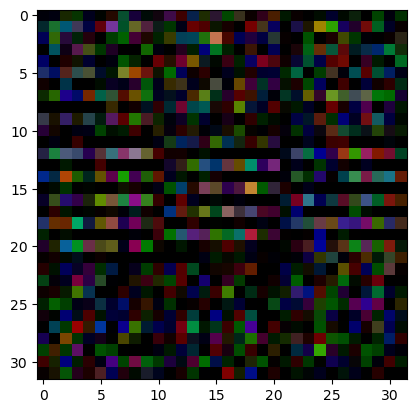

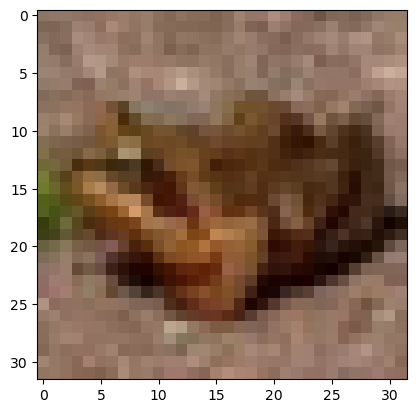

Generator loss after 100 steps = 0.5911766886711121
Generator loss after 200 steps = 0.5827947854995728
Generator loss after 300 steps = 0.5800480246543884
Generator loss after 400 steps = 0.5862805247306824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5815021991729736


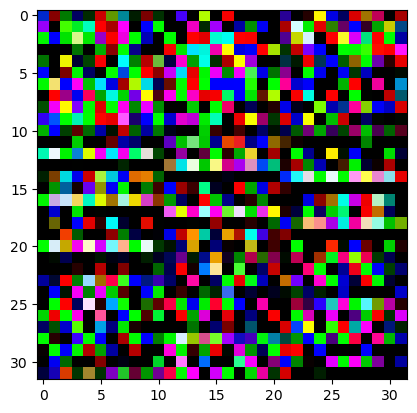

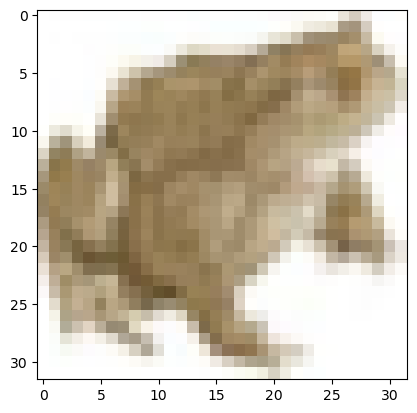

Generator loss after 600 steps = 0.5845723748207092
Generator loss after 700 steps = 0.5806278586387634
Generator loss after 800 steps = 0.5815951824188232
Generator loss after 900 steps = 0.5753010511398315
Epoch no. :  2
Discriminator loss after 0 steps = 0.7065108716487885
Discriminator loss after 100 steps = 0.690880298614502
Discriminator loss after 200 steps = 0.6892008185386658
Discriminator loss after 300 steps = 0.6765327751636505
Discriminator loss after 400 steps = 0.6855124533176422
Discriminator loss after 500 steps = 0.6593000292778015
Discriminator loss after 600 steps = 0.6907055974006653
Discriminator loss after 700 steps = 0.6872004568576813
Discriminator loss after 800 steps = 0.7028824388980865
Discriminator loss after 900 steps = 0.6791850626468658
Discriminator loss after 0 steps = 0.6781415045261383
Discriminator loss after 100 steps = 0.6791951060295105
Discriminator loss after 200 steps = 0.678236722946167
Discriminator loss after 300 steps = 0.6762629151344299

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6936160922050476


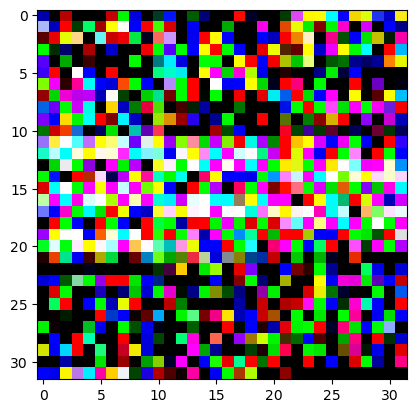

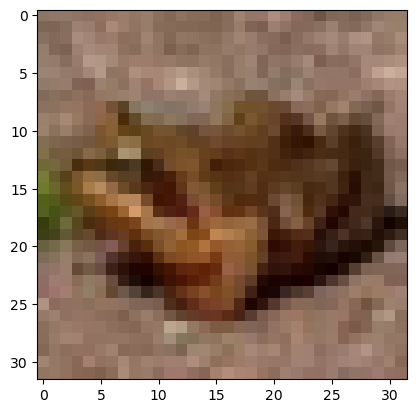

Generator loss after 100 steps = 0.588635265827179
Generator loss after 200 steps = 0.591371476650238
Generator loss after 300 steps = 0.5967810153961182
Generator loss after 400 steps = 0.5890105962753296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5825079679489136


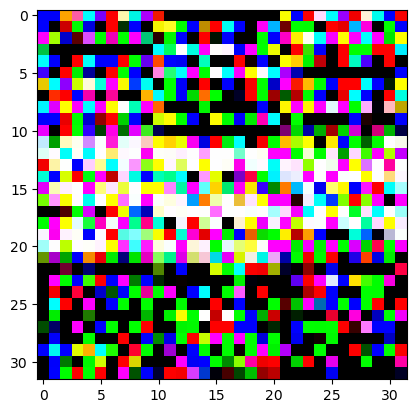

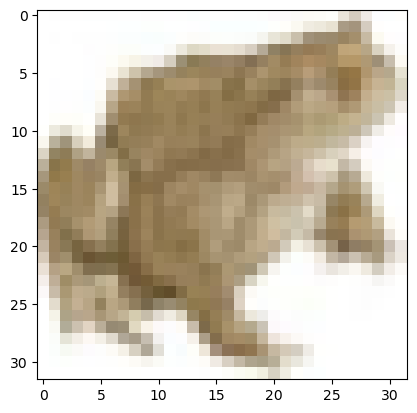

Generator loss after 600 steps = 0.5794605612754822
Generator loss after 700 steps = 0.5809224843978882
Generator loss after 800 steps = 0.5840937495231628
Generator loss after 900 steps = 0.5723651647567749
Epoch no. :  3
Discriminator loss after 0 steps = 0.6781415045261383
Discriminator loss after 100 steps = 0.6791951060295105
Discriminator loss after 200 steps = 0.678236722946167
Discriminator loss after 300 steps = 0.6762629151344299
Discriminator loss after 400 steps = 0.6854726672172546
Discriminator loss after 500 steps = 0.69001305103302
Discriminator loss after 600 steps = 0.6784693896770477
Discriminator loss after 700 steps = 0.6733328402042389
Discriminator loss after 800 steps = 0.686684250831604
Discriminator loss after 900 steps = 0.6838356256484985
Discriminator loss after 0 steps = 0.7164580821990967
Discriminator loss after 100 steps = 0.684929609298706
Discriminator loss after 200 steps = 0.6831963658332825
Discriminator loss after 300 steps = 0.6853464841842651
Di

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6117486357688904


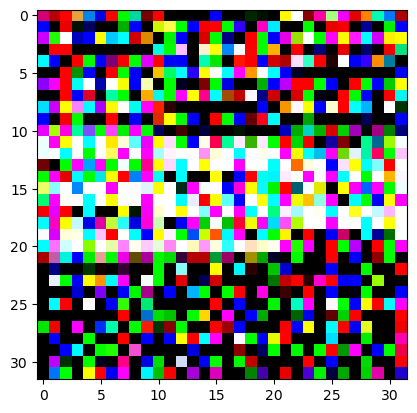

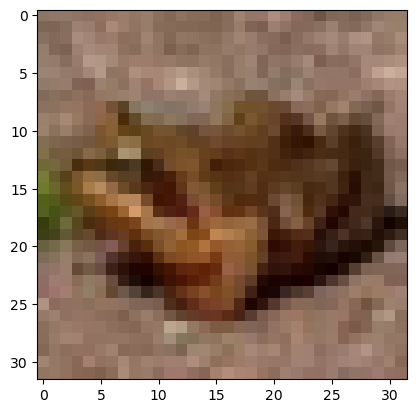

Generator loss after 100 steps = 0.5812628269195557
Generator loss after 200 steps = 0.5832018256187439
Generator loss after 300 steps = 0.5747889876365662
Generator loss after 400 steps = 0.5718639492988586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5689663290977478


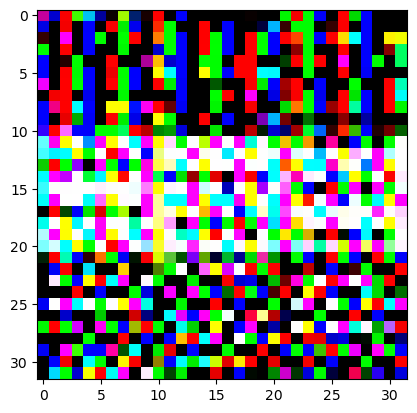

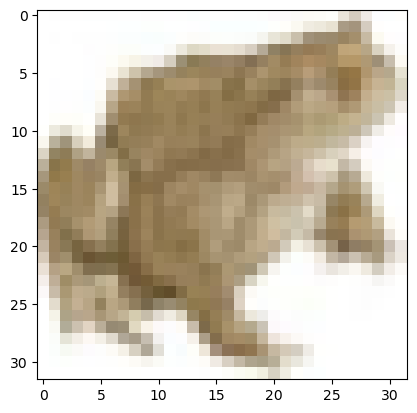

Generator loss after 600 steps = 0.5624104738235474
Generator loss after 700 steps = 0.5661592483520508
Generator loss after 800 steps = 0.566881000995636
Generator loss after 900 steps = 0.5611145496368408
Epoch no. :  4
Discriminator loss after 0 steps = 0.7164580821990967
Discriminator loss after 100 steps = 0.684929609298706
Discriminator loss after 200 steps = 0.6831963658332825
Discriminator loss after 300 steps = 0.6853464841842651
Discriminator loss after 400 steps = 0.6742567420005798
Discriminator loss after 500 steps = 0.658353716135025
Discriminator loss after 600 steps = 0.6664851307868958
Discriminator loss after 700 steps = 0.6473555862903595
Discriminator loss after 800 steps = 0.6597493886947632
Discriminator loss after 900 steps = 0.6534493267536163
Discriminator loss after 0 steps = 0.650505393743515
Discriminator loss after 100 steps = 0.6480179727077484
Discriminator loss after 200 steps = 0.6512843370437622
Discriminator loss after 300 steps = 0.6506910920143127
D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6929195523262024


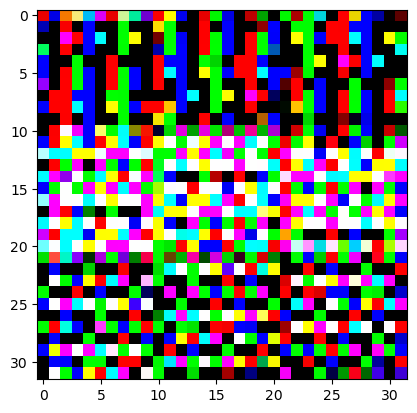

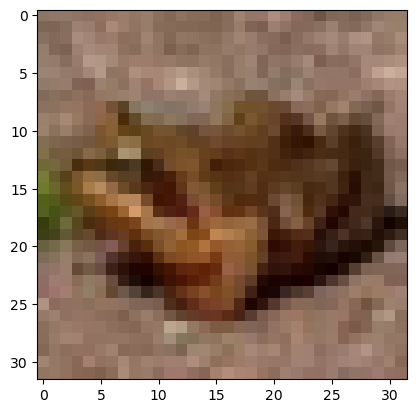

Generator loss after 100 steps = 0.5659739375114441
Generator loss after 200 steps = 0.5681853890419006
Generator loss after 300 steps = 0.5604336261749268
Generator loss after 400 steps = 0.553722620010376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5568872094154358


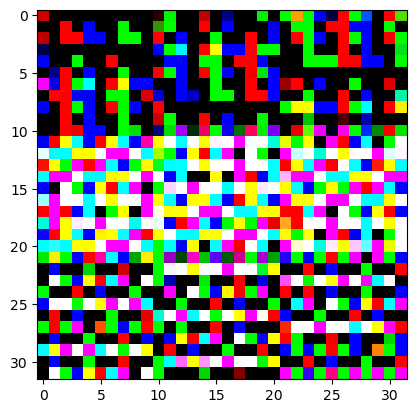

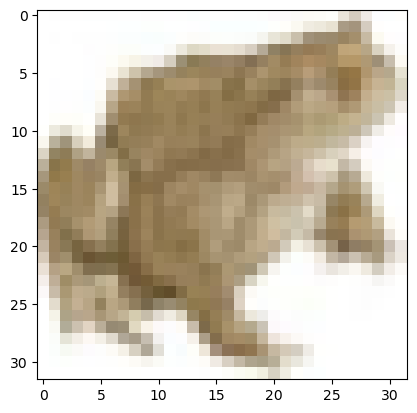

Generator loss after 600 steps = 0.5535735487937927
Generator loss after 700 steps = 0.5480965375900269
Generator loss after 800 steps = 0.5484410524368286
Generator loss after 900 steps = 0.5535145401954651
Epoch no. :  5
Discriminator loss after 0 steps = 0.650505393743515
Discriminator loss after 100 steps = 0.6480179727077484
Discriminator loss after 200 steps = 0.6512843370437622
Discriminator loss after 300 steps = 0.6506910920143127
Discriminator loss after 400 steps = 0.6514216959476471
Discriminator loss after 500 steps = 0.6541713178157806
Discriminator loss after 600 steps = 0.6360679268836975
Discriminator loss after 700 steps = 0.6450986862182617
Discriminator loss after 800 steps = 0.648146778345108
Discriminator loss after 900 steps = 0.6395423710346222
Discriminator loss after 0 steps = 0.6404948830604553
Discriminator loss after 100 steps = 0.6454775631427765
Discriminator loss after 200 steps = 0.640390932559967
Discriminator loss after 300 steps = 0.6538473665714264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6912828087806702


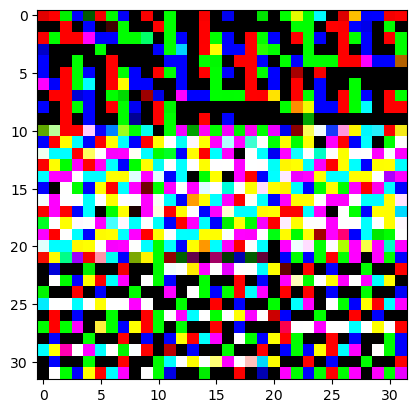

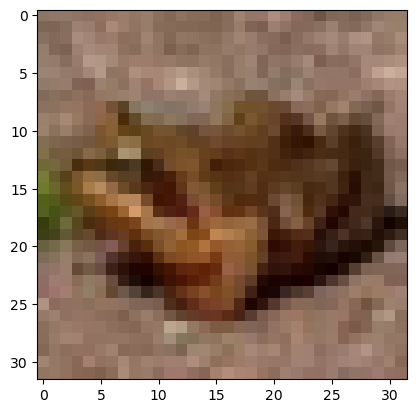

Generator loss after 100 steps = 0.582381546497345
Generator loss after 200 steps = 0.5669965744018555
Generator loss after 300 steps = 0.5821979641914368
Generator loss after 400 steps = 0.5698244571685791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.568587601184845


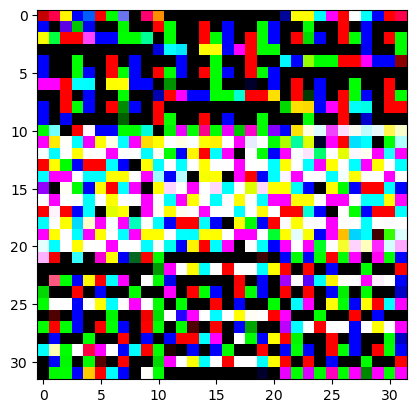

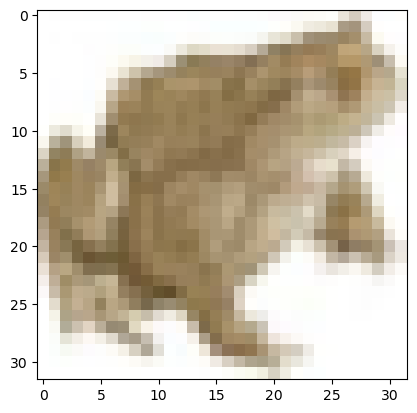

Generator loss after 600 steps = 0.5658969879150391
Generator loss after 700 steps = 0.5682879686355591
Generator loss after 800 steps = 0.5700547099113464
Generator loss after 900 steps = 0.5663512349128723
Epoch no. :  6
Discriminator loss after 0 steps = 0.6404948830604553
Discriminator loss after 100 steps = 0.6454775631427765
Discriminator loss after 200 steps = 0.640390932559967
Discriminator loss after 300 steps = 0.6538473665714264
Discriminator loss after 400 steps = 0.6437153816223145
Discriminator loss after 500 steps = 0.6400674283504486
Discriminator loss after 600 steps = 0.6298038065433502
Discriminator loss after 700 steps = 0.65339794754982
Discriminator loss after 800 steps = 0.6494289636611938
Discriminator loss after 900 steps = 0.6299837529659271
Discriminator loss after 0 steps = 0.7145965695381165
Discriminator loss after 100 steps = 0.6615612506866455
Discriminator loss after 200 steps = 0.6578870117664337
Discriminator loss after 300 steps = 0.6641823351383209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6961727142333984


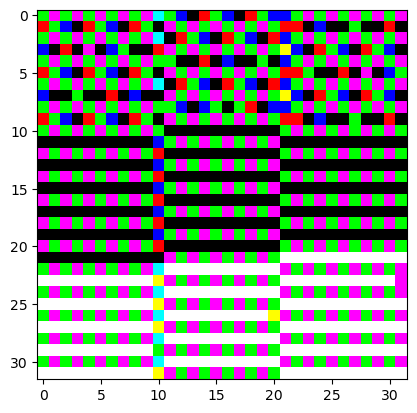

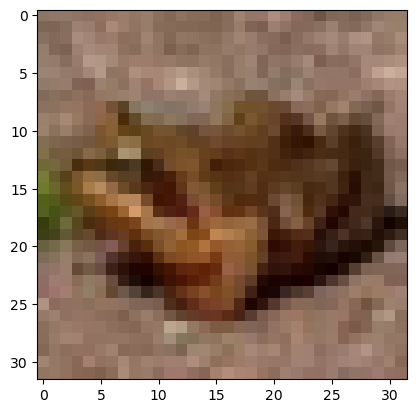

Generator loss after 100 steps = 0.5710119605064392
Generator loss after 200 steps = 0.5734721422195435
Generator loss after 300 steps = 0.5925753116607666
Generator loss after 400 steps = 0.5704320073127747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5640786290168762


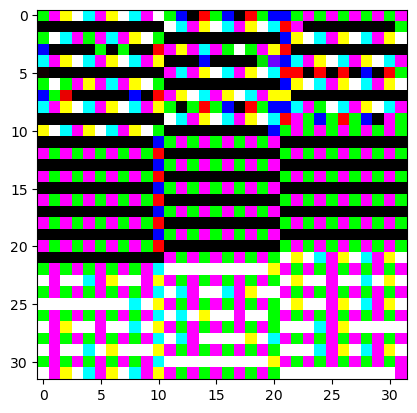

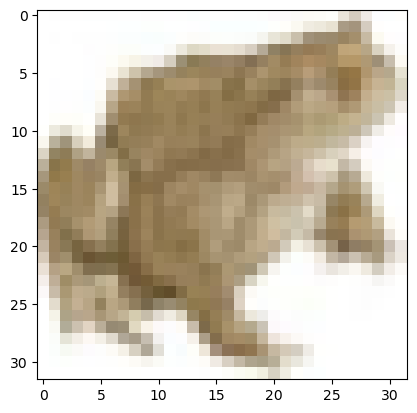

Generator loss after 600 steps = 0.5642351508140564
Generator loss after 700 steps = 0.5735076665878296
Generator loss after 800 steps = 0.5624244213104248
Generator loss after 900 steps = 0.5589912533760071
Epoch no. :  7
Discriminator loss after 0 steps = 0.7145965695381165
Discriminator loss after 100 steps = 0.6615612506866455
Discriminator loss after 200 steps = 0.6578870117664337
Discriminator loss after 300 steps = 0.6641823351383209
Discriminator loss after 400 steps = 0.6358171105384827
Discriminator loss after 500 steps = 0.6505980491638184
Discriminator loss after 600 steps = 0.6562744379043579
Discriminator loss after 700 steps = 0.6348565220832825
Discriminator loss after 800 steps = 0.6429174840450287
Discriminator loss after 900 steps = 0.6319855749607086
Discriminator loss after 0 steps = 0.6564507186412811
Discriminator loss after 100 steps = 0.6549027562141418
Discriminator loss after 200 steps = 0.6839170157909393
Discriminator loss after 300 steps = 0.65551024675369

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 0 steps = 0.6918386816978455


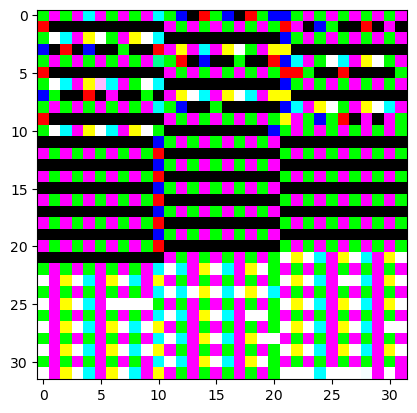

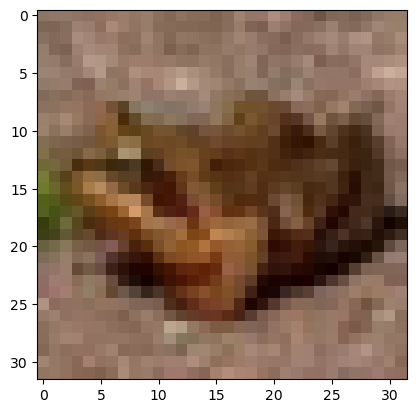

Generator loss after 100 steps = 0.5379130244255066
Generator loss after 200 steps = 0.53212970495224
Generator loss after 300 steps = 0.5893847346305847
Generator loss after 400 steps = 0.5919504165649414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss after 500 steps = 0.5659347176551819


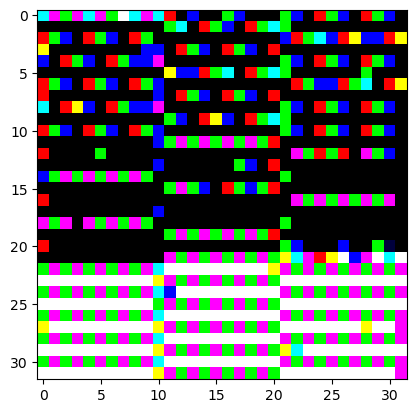

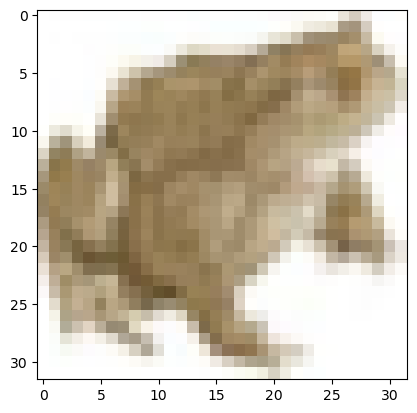

Generator loss after 600 steps = 0.5723552703857422
Generator loss after 700 steps = 0.5864814519882202
Generator loss after 800 steps = 0.5789632797241211
Generator loss after 900 steps = 0.5430116653442383
Epoch no. :  8
Discriminator loss after 0 steps = 0.6564507186412811
Discriminator loss after 100 steps = 0.6549027562141418
Discriminator loss after 200 steps = 0.6839170157909393
Discriminator loss after 300 steps = 0.6555102467536926
Discriminator loss after 400 steps = 0.6383478045463562
Discriminator loss after 500 steps = 0.6321017444133759
Discriminator loss after 600 steps = 0.6469025611877441
Discriminator loss after 700 steps = 0.6300770044326782
Discriminator loss after 800 steps = 0.6287380158901215
Discriminator loss after 900 steps = 0.6394002139568329
Discriminator loss after 0 steps = 0.7147862613201141
Discriminator loss after 100 steps = 0.6262856423854828
Discriminator loss after 200 steps = 0.6980616748332977
Discriminator loss after 300 steps = 0.65054932236671

In [ ]:
g_lr = 2e-4
for g_lr in np.arange(9e-5, 4e-4, 2e-5):
    for d_lr in np.arange(4e-5, 2e-4, 2e-5):
        for k in np.arange(2,5, 1):
            disc = Discriminator().to(device)
            gen = Generator().to(device)
            l_disc, l_gen, img = train(num_epochs=10, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=50, disc_lr=d_lr, gen_lr=g_lr, k=k)
            loss_disc.append(l_disc)
            loss_gen.append(l_gen)
            images.append(img)

In [ ]:
g_lr = 3e-4
d_lr = 9e-5
k = 5
num_epochs = 10
l_disc, l_gen, img = train(num_epochs, data_dir=data_dir,data_dir_val=data_dir_val, device=device, batch_size=125, disc_lr=d_lr, gen_lr=g_lr, k=k)
loss_disc.append(l_disc)
loss_gen.append(l_gen)
images.append(img)

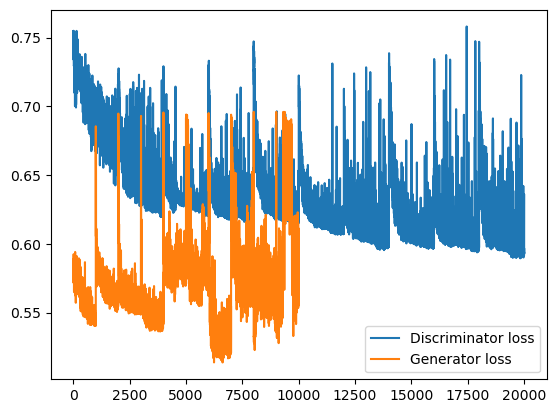

In [55]:
for i in range(len(loss_gen)):
    plt.plot(loss_disc[i])
    plt.plot(loss_gen[i])
    plt.legend(["Discriminator loss", "Generator loss"])
    plt.show()
    # plt.imshow(images[i][-1].reshape(32, 32, 3).cpu())
    plt.show()
    # plt., loss_d[0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.0856e-03,
            2.0939e-01,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.3252e-01,
           -2.6413e-02,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
     

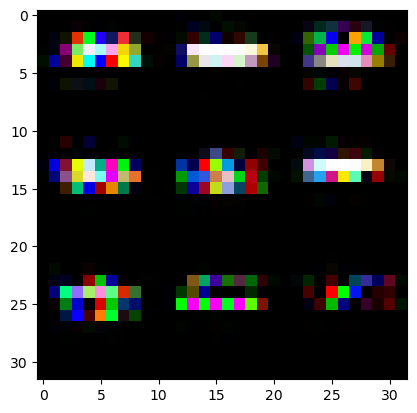

In [24]:
with torch.no_grad():
    gen_img = gen(torch.randn(10, dim_z, 1, 1, device=device))
    print(gen_img)
    plt.imshow(gen_img[1].reshape(32, 32, 3).cpu().detach().numpy())
    # print(disc(gen_img).flatten())

In [ ]:
loss_fn = torch.nn.BCELoss()

train_dataset = TrainDataset(data_dir)
train_sampler = DistributedSampler(train_dataset, num_replicas=1, rank=0)
batch_size = 50
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    sampler=train_sampler,
)
if train == False:
    val_dataset = ValDataset(data_dir_val)
    val_sampler = DistributedSampler(val_dataset, num_replicas=1, rank=0)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        sampler=val_sampler,
    )

optimG = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.0))
optimD = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.0))

# for j, mini_batch in enumerate(train_loader):
mini_batch = next(iter(train_loader))
optimG.zero_grad()

for _ in range(3):
    optimD.zero_grad()

    # train disc first
    x_real = mini_batch["img"].to(device)
    x_real = x_real.view(batch_size, num_in_channels, 32, 32)
    labels = torch.full(
        (batch_size,), 1.0, dtype=torch.float32, device=device
    )
    # out_disc_r = disc(x_real).flatten().sigmoid()
    out_disc_r = disc(x_real).flatten()

    # print(out_disc_r)
    loss_disc_r = loss_fn(out_disc_r, labels)
    loss_disc_r.backward()

    x_fake = gen(torch.randn(batch_size, dim_z, 1, 1))
    labels = torch.full(
        (batch_size,), 0.0, dtype=torch.float32, device=device
    )
    # out_disc_f = disc(x_fake).flatten().sigmoid()
    out_disc_f = disc(x_fake).flatten()
    loss_disc_f = loss_fn(out_disc_f, labels)
    loss_disc_f.backward()

    loss_disc = (
        loss_disc_f.mean().item() + loss_disc_r.mean().item()
    ) / 2.0
    if _ != 2:
        optimD.step()

# train gen
x_gen = gen(torch.randn(batch_size, dim_z, 1, 1))
# out = disc(x_gen).flatten().sigmoid()
out = disc(x_gen).flatten()
labels = torch.full(
    (batch_size,), 1.0, dtype=torch.float32, device=device
)
loss_gen = loss_fn(out, labels)
loss_gen.backward()


# optimG.step()

In [ ]:
def train(gpu, args):
    rank = args.nr * args.gpus + gpu
    torch.distributed.init_process_group(
        backend="nccl",
        init_method="env://",
        world_size=args.world_size,
        rank=rank,
    )

    torch.manual_seed(0)
    torch.cuda.set_device(gpu)
    model = test_net().cuda(gpu)

    batch_size = 100

    loss_fn = torch.nn.BCELoss()
    optim = torch.optim.Adam(model.parameters(), lr=1e4)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
    # model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
    # model = DDP(model)

    total_steps = len(train_loader)
    for epoch in range(args.epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            if (i + 1) % 100 == 0 and gpu == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                        epoch + 1, args.epochs, i + 1, total_steps, loss.item()
                    )
                )